In [156]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from datetime import date, datetime, timedelta
import pytz

In [157]:
stock_list = ['AAPL', 'MSFT', 'GOOG','AMZN']
start_date, end_date = '2020-01-01', '2022-12-31'

In [158]:
#functions to source new data
def get_stock_data(ticker,start_date,end_date):
    stock_data = yf.Ticker(ticker).history(start=start_date,end=end_date).reset_index()
    return stock_data

def get_sp500(start_date,end_date):
    sp500_data = yf.Ticker("^GSPC").history(start=start_date, end=end_date).reset_index()
    return sp500_data

In [159]:
class DataProcessing:
    def __init__(self, data):
        for column in data.columns:
            setattr(self,column.lower(),np.array(data[column]))

    def gen_train_test(self,train_percent_len):
        self.Y_train = self.close[0:round(train_percent_len*(len(self.close)))]
        self.X_train = self.date[0:round(train_percent_len*(len(self.date)))]
        self.Y_test = self.close[round(train_percent_len*(len(self.close))):len(self.close)]
        self.X_test = self.date[round(train_percent_len*(len(self.date))):len(self.date)]

        return self.X_train, self.Y_train, self.X_test, self.Y_test

In [160]:
stock_dict = {}
ma_day = [10,20,50]
for stock in stock_list:
    get_stock_data(stock, start_date, end_date).to_csv(stock + ".csv",index=False) #uncomment to get new data
    stock_dict[stock] = pd.read_csv(stock + ".csv")
    stock_dict[stock]['Date'] = stock_dict[stock]['Date'].apply(lambda x: datetime.fromisoformat(x).astimezone(pytz.utc))
    
    #calculated moving average stock prices
    for ma in ma_day:
        var_name = f"{ma}-day MA Close"
        stock_dict[stock][var_name] = stock_dict[stock]['Close'].rolling(ma).mean()
    

In [161]:
stock_dict['AAPL'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,10-day MA Close,20-day MA Close,50-day MA Close
0,2020-01-02 05:00:00+00:00,72.344239,73.408991,72.087823,73.347939,135480400,0.0,0.0,NaN,NaN,NaN
1,2020-01-03 05:00:00+00:00,72.566464,73.404096,72.407730,72.634842,146322800,0.0,0.0,NaN,NaN,NaN
2,2020-01-06 05:00:00+00:00,71.745937,73.252697,71.491958,73.213623,118387200,0.0,0.0,NaN,NaN,NaN
3,2020-01-07 05:00:00+00:00,73.223383,73.482243,72.647055,72.869286,108872000,0.0,0.0,NaN,NaN,NaN
4,2020-01-08 05:00:00+00:00,72.568913,74.346749,72.568913,74.041489,132079200,0.0,0.0,NaN,NaN,NaN


In [162]:
stock_dict['AAPL'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Date             756 non-null    datetime64[ns, UTC]
 1   Open             756 non-null    float64            
 2   High             756 non-null    float64            
 3   Low              756 non-null    float64            
 4   Close            756 non-null    float64            
 5   Volume           756 non-null    int64              
 6   Dividends        756 non-null    float64            
 7   Stock Splits     756 non-null    float64            
 8   10-day MA Close  747 non-null    float64            
 9   20-day MA Close  737 non-null    float64            
 10  50-day MA Close  707 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(9), int64(1)
memory usage: 65.1 KB


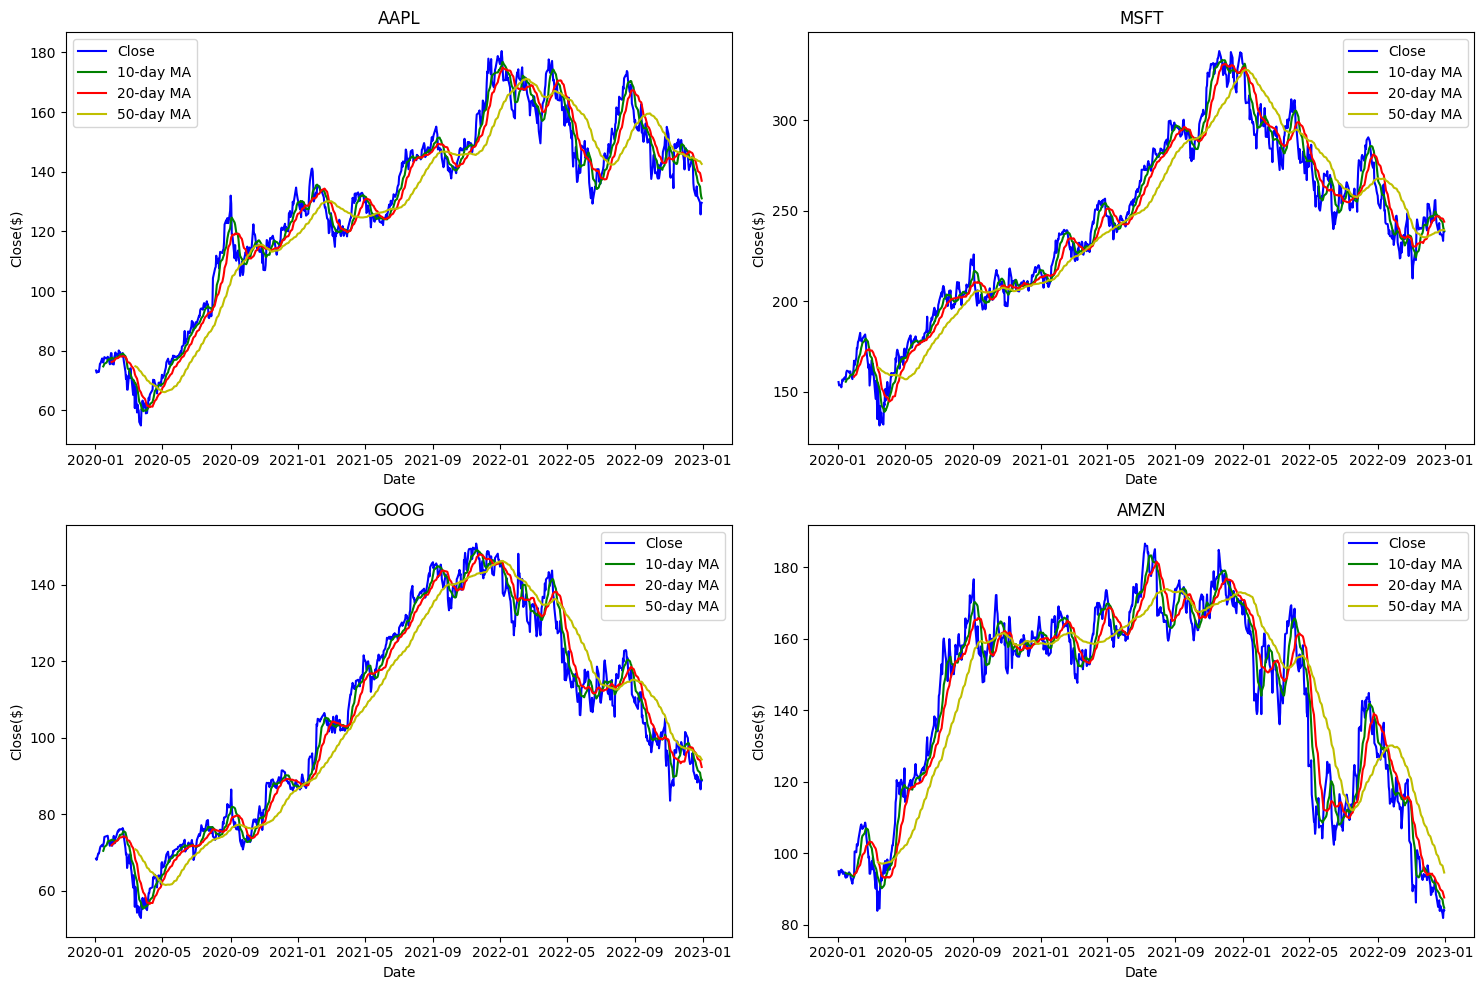

In [163]:
fig, axs = plt.subplots(math.ceil(len(stock_dict)/2),2, figsize = (15,10))    

for i, stock in enumerate(stock_list):
    ax_x, ax_y = i//2, math.ceil(i/2)-i//2
    ax = axs[ax_x, ax_y]
    ax.plot(stock_dict[stock]['Date'],stock_dict[stock]['Close'], color = 'b', label = 'Close') #plot close
    ax.plot(stock_dict[stock]['Date'],stock_dict[stock]['10-day MA Close'], color = 'g', label = '10-day MA') #plot 10-day MA
    ax.plot(stock_dict[stock]['Date'],stock_dict[stock]['20-day MA Close'], color = 'r', label = '20-day MA') #plot 20-day MA
    ax.plot(stock_dict[stock]['Date'],stock_dict[stock]['50-day MA Close'], color = 'y', label = '50-day MA')#plot 50-day MA
    ax.legend(loc='best')
    
    ax.set_ylabel('Close($)')
    ax.set_xlabel('Date')
    ax.set_title(f"{stock}")
    
plt.tight_layout()
plt.show()
